In [1]:
import numpy as np
from json_tricks import dumps, loads
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.model_selection import train_test_split

import pickle

In [2]:
i = 0
lines = []
with open("data/data4_valid/fl4-comb-new.txt") as f:
    for line in f:
        lines.append(line)

In [3]:
Qs = []
for i in tqdm(range(len(lines))):
    map_str_comb, dic = lines[i].split("\t")
    obj = loads(dic)
    Qs.append(obj['Q'])
#     print(map_str_comb)
#     print(obj['Q'])
#     print(obj['start'])
#     print(obj['end'])
#     print(obj['score'])

100%|██████████| 3828/3828 [00:20<00:00, 184.80it/s]


In [4]:
data = pd.DataFrame(np.array([list(q.flatten()) for q in Qs]))
# data

In [5]:
np.array(data.describe().loc['mean']).reshape((16,4))

array([[0.12605694, 0.0833256 , 0.08297108, 0.12353941],
       [0.08128873, 0.05724625, 0.05659838, 0.09661872],
       [0.08087064, 0.05331417, 0.06352362, 0.08263363],
       [0.08988946, 0.08878639, 0.12008143, 0.09073982],
       [0.09580999, 0.05698207, 0.05771588, 0.08112013],
       [0.05099827, 0.05139299, 0.05043681, 0.05229824],
       [0.07261287, 0.07937687, 0.07230626, 0.06553421],
       [0.11599771, 0.18485035, 0.1737943 , 0.11099252],
       [0.08197991, 0.06288321, 0.05389169, 0.07824682],
       [0.06590338, 0.06913064, 0.07649124, 0.06986908],
       [0.1207364 , 0.15513544, 0.14925819, 0.12778036],
       [0.22836985, 0.39108632, 0.36243487, 0.22880617],
       [0.09093449, 0.11885227, 0.09104228, 0.08888373],
       [0.11384063, 0.17271849, 0.18458059, 0.1095291 ],
       [0.23501638, 0.35944002, 0.38642703, 0.23150493],
       [0.        , 0.        , 0.        , 0.        ]])

In [22]:
np.array(data.describe().loc['mean'])

array([0.12605694, 0.0833256 , 0.08297108, 0.12353941, 0.08128873,
       0.05724625, 0.05659838, 0.09661872, 0.08087064, 0.05331417,
       0.06352362, 0.08263363, 0.08988946, 0.08878639, 0.12008143,
       0.09073982, 0.09580999, 0.05698207, 0.05771588, 0.08112013,
       0.05099827, 0.05139299, 0.05043681, 0.05229824, 0.07261287,
       0.07937687, 0.07230626, 0.06553421, 0.11599771, 0.18485035,
       0.1737943 , 0.11099252, 0.08197991, 0.06288321, 0.05389169,
       0.07824682, 0.06590338, 0.06913064, 0.07649124, 0.06986908,
       0.1207364 , 0.15513544, 0.14925819, 0.12778036, 0.22836985,
       0.39108632, 0.36243487, 0.22880617, 0.09093449, 0.11885227,
       0.09104228, 0.08888373, 0.11384063, 0.17271849, 0.18458059,
       0.1095291 , 0.23501638, 0.35944002, 0.38642703, 0.23150493,
       0.        , 0.        , 0.        , 0.        ])

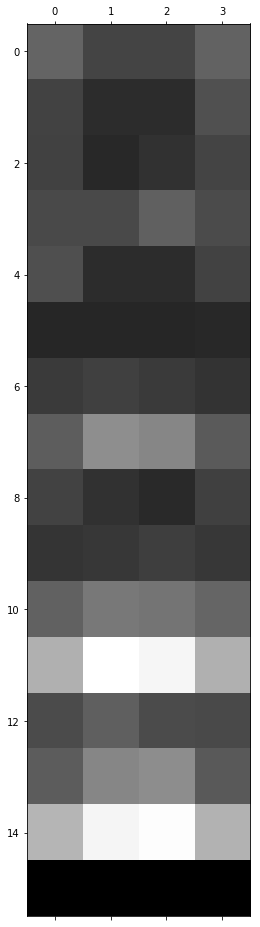

In [6]:
plt.matshow(np.array(data.describe().loc['mean']).reshape((16,4)), cmap='Greys_r')

In [7]:
q_data = np.array([q.flatten() for q in Qs])

In [8]:
X_train, X_test = train_test_split(q_data, test_size=0.10, random_state=42)

In [9]:
X_test[100]

array([-2.16377471e-03,  4.76247463e-03, -3.72915789e-04,  5.47921725e-02,
        1.61420948e-02, -1.77593953e-03, -2.27810865e-03,  1.23271672e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.93360790e-02,  8.70303075e-02,  4.14953570e-01,  3.60708108e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.49819926e-03, -2.44130913e-03, -2.41167584e-03, -8.09420665e-04,
       -1.53353350e-03,  9.93214391e-02,  6.80018972e-02,  7.46301022e-02,
        3.68077790e-01,  7.58032172e-01,  3.69968455e-01,  3.54609095e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.46718768e-03,  6.82141150e-01,  5.50165250e-02, -1.34924672e-03,
        2.10026171e-01,  9.83456490e-02,  9.72448049e-01,  4.48880585e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [10]:
mb_size = 32
Z_dim = 100
X_dim = X_train.shape[1]
# X_dim = mnist.train.images.shape[1]
h_dim = 40
c = 0
lr = 1e-3

In [11]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [12]:
""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [13]:
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [14]:
""" ===================== TRAINING ======================== """

def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size))
zeros_label = Variable(torch.zeros(mb_size))

In [15]:
def next_batch(num, data):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    return data[idx]

In [16]:
for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mb_size, Z_dim))
#     X, _ = mnist.train.next_batch(mb_size)
    X = next_batch(mb_size, X_train)
    X = Variable(torch.from_numpy(X).float())

    # Dicriminator forward-loss-backward-update
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mb_size, Z_dim))
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        samples = G(z).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(16, 4), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(c).zfill(3)), bbox_inches='tight')
        c += 1
        plt.close(fig)

/Users/gvsi/anaconda3/envs/gan/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Iter-0; D_loss: [1.0959744]; G_loss: [1.3927464]
Iter-1000; D_loss: [1.1537104]; G_loss: [1.1945972]
Iter-2000; D_loss: [1.0708642]; G_loss: [0.9161543]
Iter-3000; D_loss: [1.1765244]; G_loss: [0.8007257]
Iter-4000; D_loss: [1.1176058]; G_loss: [0.933995]
Iter-5000; D_loss: [1.2397776]; G_loss: [0.92559123]
Iter-6000; D_loss: [1.2252352]; G_loss: [0.7989011]
Iter-7000; D_loss: [1.2462945]; G_loss: [1.0362389]
Iter-8000; D_loss: [1.3048198]; G_loss: [0.70606285]
Iter-9000; D_loss: [1.3573613]; G_loss: [0.8641703]
Iter-10000; D_loss: [1.2790121]; G_loss: [0.785764]
Iter-11000; D_loss: [1.214653]; G_loss: [0.89359033]
Iter-12000; D_loss: [1.3786997]; G_loss: [0.8635296]
Iter-13000; D_loss: [1.3282288]; G_loss: [0.8703219]
Iter-14000; D_loss: [1.2864697]; G_loss: [0.79983693]
Iter-15000; D_loss: [1.2704588]; G_loss: [0.89859056]
Iter-16000; D_loss: [1.2395549]; G_loss: [0.8264526]
Iter-17000; D_loss: [1.3191288]; G_loss: [0.84736335]
Iter-18000; D_loss: [1.3775992]; G_loss: [0.9206655]
Ite

In [ ]:
inputs = Variable(torch.from_numpy(X_test[:32]).float(), requires_grad=True)

In [ ]:
inputs[0].data.numpy().reshape((16,4))

In [18]:
myD = D(inputs)

In [19]:
myD

Variable containing:
 0.6570
 0.3254
 0.3938
 0.1476
 0.7991
 0.7262
 0.2260
 0.5738
 0.8807
 0.6340
 0.3272
 0.2798
 0.6505
 0.3209
 0.9394
 0.4927
 0.1952
 0.0693
 0.2091
 0.3245
 0.5301
 0.3456
 0.9675
 0.3239
 0.2765
 0.4952
 0.5312
 0.4809
 0.6414
 0.7416
 0.4703
 0.4125
[torch.FloatTensor of size 32x1]

In [20]:
myD.backward(ones_label)

In [21]:
inputs.grad.data.numpy()[0].reshape((16,4))

array([[-8.26253369e-02,  1.61539644e-01,  3.82690251e-01,
         3.82950276e-01],
       [-1.80268359e+00, -7.07610369e+00, -1.10227404e+01,
        -3.33039308e+00],
       [-4.70180847e-02, -3.64446253e-01, -2.50311941e-01,
         6.85633481e-01],
       [-1.15009390e-01, -3.49157870e-01, -1.31591940e+00,
         2.71643847e-01],
       [ 1.70627356e-01,  2.83755571e-01,  2.91358024e-01,
         2.72754520e-01],
       [-1.60105661e-01, -4.29261833e-01, -3.17726433e-01,
        -1.93338469e-01],
       [-1.08871513e+02, -3.79472656e+01, -8.99551697e+01,
        -1.18808876e+02],
       [-2.02404514e-01, -4.95498925e-01,  1.85605258e-01,
        -4.98765260e-01],
       [ 3.90781999e-01, -2.26147920e-01, -2.55456734e-02,
        -2.13494718e-01],
       [ 3.09839189e-01, -2.82146722e-01, -2.10579664e-01,
        -1.99370444e-01],
       [-2.96096146e-01, -1.39825881e-01, -1.86250731e-01,
        -3.18873435e-01],
       [-9.59123421e+00, -1.28624001e+01, -9.65364742e+00,
      

In [22]:
inputs2 = inputs.data.numpy()[0]

In [23]:
inputs2

array([ 2.0413351e-01,  5.3565968e-02, -4.8952142e-04,  4.6540376e-02,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        2.4128921e-01,  4.8542872e-02,  5.9283283e-02,  4.6531204e-02,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        2.6197243e-01,  6.8191029e-02,  4.2327818e-01,  4.5908786e-02,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        3.9717063e-01,  6.4666504e-01,  3.8751873e-01,  4.4254178e-01,
        5.2033836e-01,  8.7208027e-01,  1.7182477e-02,  1.8739057e-01,
      

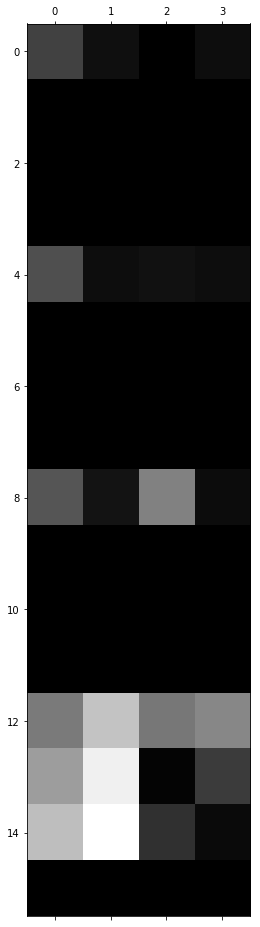

In [24]:
plt.matshow(inputs2.reshape((16,4)), cmap='Greys_r')

In [25]:
D(Variable(torch.from_numpy(inputs2.flatten()).float(), requires_grad=True))

Variable containing:
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
 0.6570
[torch.FloatTensor of size 64x1]

In [17]:
pickle.dump(G_params, open("data/gan/G_params.p", "wb" ))

In [18]:
pickle.dump(D_params, open("data/gan/D_params.p", "wb" ))

In [ ]:
self.start = datetime.now()
lr = .8
e = 0.1
y = .95
#create lists to contain total rewards and steps per episode
jList = []
rList = []
for i in tqdm(range(self.num_episodes)):
    #Reset environment and get first new observation
    s = self.env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 200:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = None
        if random.uniform(0,1) < e:
            a = self.env.action_space.sample()
        else:
            a = np.argmax(self.Q[s,:])
        #Get new state and reward from environment
        s1,r,d,_ = self.env.step(a)
        if d == True and r != 1:
            self.Q[s, a] -= 0.01
        #Update Q-Table with new knowledge
        self.Q[s,a] = self.Q[s,a] + lr*(r + y*np.max(self.Q[s1,:]) - self.Q[s,a])
        rAll += r
        s = s1
        if d == True and r > 0:
            self.train_successes.append((i, j))
        if d == True:
            #Reduce chance of random action as we train the model.
#             e = 1./((i/50) + 10)
            break
    rList.append(rAll)
self.done = True
self.end = datetime.now()
self.score = sum(rList)/self.num_episodes